### T-Test

In [1]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
from scipy import stats

# generate data
N = 10
a = np.random.randn(N) + 2 # mean 2, variance 1
b = np.random.randn(N) # mean 0, variance 1

# roll your own t-test:
var_a = a.var(ddof=1) # unbiased estimator, divide by N-1 instead of N
var_b = b.var(ddof=1)
s = np.sqrt( (var_a + var_b) / 2 ) # balanced standard deviation
t = (a.mean() - b.mean()) / (s * np.sqrt(2.0/N)) # t-statistic
df = 2*N - 2 # degrees of freedom
p = 1 - stats.t.cdf(np.abs(t), df=df) # one-sided test p-value
print("t:\t", t, "p:\t", 2*p) # two-sided test p-value

# built-in t-test:
t2, p2 = stats.ttest_ind(a, b)
print("t2:\t", t2, "p2:\t", p2)

t:	 5.408829885780405 p:	 3.8658162057503276e-05
t2:	 5.408829885780405 p2:	 3.865816205764764e-05


### Chi-square test

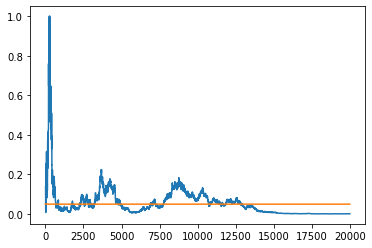

In [3]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, chi2_contingency

# contingency table
#        click       no click
#------------------------------
# ad A |   a            b
# ad B |   c            d
#
# chi^2 = (ad - bc)^2 (a + b + c + d) / [ (a + b)(c + d)(a + c)(b + d)]
# degrees of freedom = (#cols - 1) x (#rows - 1) = (2 - 1)(2 - 1) = 1

# short example

# T = np.array([[36, 14], [30, 25]])
# c2 = np.linalg.det(T)**2 * T.sum() / ( T[0].sum()*T[1].sum()*T[:,0].sum()*T[:,1].sum() )
# p_value = 1 - chi2.cdf(x=c2, df=1)

# equivalent:
# (36-31.429)**2/31.429+(14-18.571)**2/18.571 + (30-34.571)**2/34.571 + (25-20.429)**2/20.429


class DataGenerator:
  def __init__(self, p1, p2):
    self.p1 = p1
    self.p2 = p2

  def next(self):
    click1 = 1 if (np.random.random() < self.p1) else 0
    click2 = 1 if (np.random.random() < self.p2) else 0
    return click1, click2


def get_p_value(T):
  # same as scipy.stats.chi2_contingency(T, correction=False)
  det = T[0,0]*T[1,1] - T[0,1]*T[1,0]      #calculate the determinant of the matrix
  c2 = float(det) / T[0].sum() * det / T[1].sum() * T.sum() / T[:,0].sum() / T[:,1].sum()
  p = 1 - chi2.cdf(x=c2, df=1)
  return p


def run_experiment(p1, p2, N):
  data = DataGenerator(p1, p2)
  p_values = np.empty(N)
  T = np.zeros((2, 2)).astype(np.float32)
  for i in range(N):
    c1, c2 = data.next()
    T[0,c1] += 1
    T[1,c2] += 1
    # ignore the first 10 values
    if i < 10:
      p_values[i] = None
    else:
      p_values[i] = get_p_value(T)
  plt.plot(p_values)
  plt.plot(np.ones(N)*0.05)
  plt.show()

run_experiment(0.1, 0.11, 20000)


### The Bandit problem
This algorithm deals with the dilemma exploitation-exploration. We want to find significant results while making the most during the experiment. In other words, in the case of an AB test, giving more trials to the version that performs better

current samples: ['0.6805', '0.7324', '0.6748']


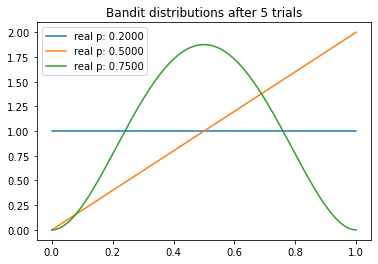

current samples: ['0.3607', '0.8120', '0.6394']


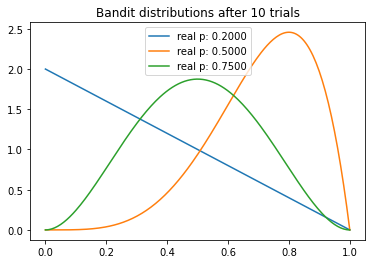

current samples: ['0.0761', '0.4566', '0.6583']


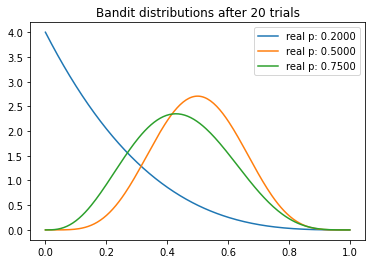

current samples: ['0.3565', '0.2231', '0.7519']


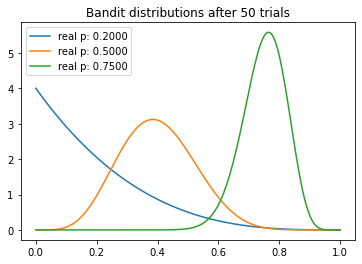

current samples: ['0.2931', '0.1280', '0.8195']


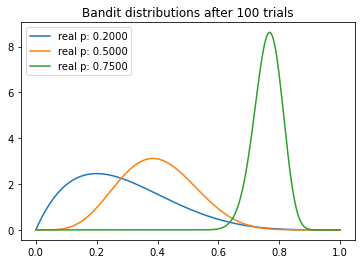

current samples: ['0.1401', '0.4973', '0.6887']


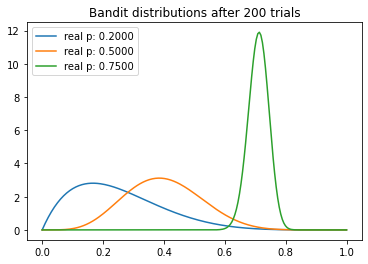

current samples: ['0.2236', '0.3725', '0.7633']


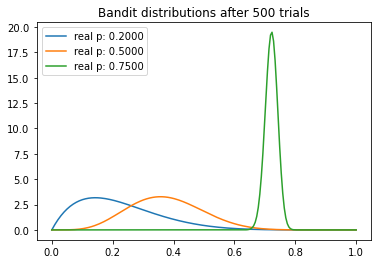

current samples: ['0.1160', '0.6772', '0.7468']


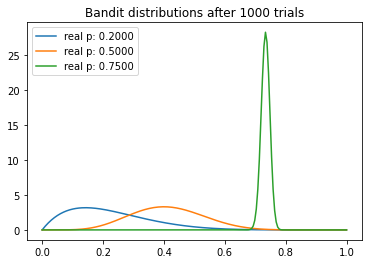

current samples: ['0.2242', '0.4031', '0.7330']


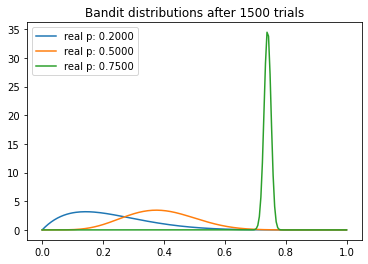

current samples: ['0.1282', '0.4646', '0.7450']


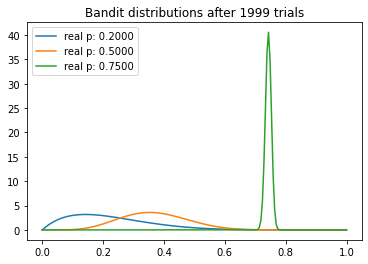

In [13]:

from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta


NUM_TRIALS = 2000
#define the true click through rates
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]


class Bandit(object):
  def __init__(self, p):
    #probability of winning
    self.p = p
    #the beta parameters 
    self.a = 1
    self.b = 1
    #since they are 1 = uniform distribution

#if a random number is smaller than p, then return 1, else 0
#sampling from the true distribution
  def pull(self):
    return np.random.random() < self.p
#sample from the beta distribution with parameters a and b. We are sampling from the posterior distritbution
# our estimated distribution
  def sample(self):
    return np.random.beta(self.a, self.b)

  def update(self, x):
    self.a += x
    self.b += 1 - x


def plot(bandits, trial):
  x = np.linspace(0, 1, 200)
  for b in bandits:
    y = beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label="real p: %.4f" % b.p)
  plt.title("Bandit distributions after %s trials" % trial)
  plt.legend()
  plt.show()


def experiment():
    #initialise an array of bandits
    #assingn probabilities to each bandid
  bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]

    #the points for the plot (the x)
  sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
  for i in range(NUM_TRIALS): #total amout of trials (for each trial)

    # take a sample from each bandit
    bestb = None
    maxsample = -1
    allsamples = [] # let's collect these just to print for debugging
    for b in bandits:
      sample = b.sample()
      allsamples.append("%.4f" % sample)
      if sample > maxsample:
        maxsample = sample
        bestb = b
    if i in sample_points:
      print("current samples: %s" % allsamples)
      plot(bandits, i)

    # pull the arm for the bandit with the largest sample
    x = bestb.pull()

    # update the distribution for the bandit whose arm we just pulled
    bestb.update(x)


if __name__ == "__main__":
  experiment()

In [12]:
 np.random.beta(1, 1)

0.9748611228586634